Final Project for 6120

Instruction to run:

Put the 3 input files, **test.csv, train.csv, and glove.6B.50d.txt** under the same directory as this Jupiter file.

Compile this Jupiter file.


# Model 1

In [1]:
# import packages
import pandas as pd, numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import re, string
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# load data
# please prepare the file "train.csv", "test.csv" and glove.6B
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# display data
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# generate a describe of the data to get a different perspective
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['clean'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# fill the na value to unknown
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)

In [6]:
# remove punctuations and tokenize the text
def tokenize(s): 
  regulated_tokens = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
  return regulated_tokens .sub(r' \1 ', s).split()

In [7]:
# because the test data has no label, we will use split train data to test the result of this model
train, test = train_test_split(train, test_size=0.2, random_state=25)  

In [8]:
# apply tfidf vectorizer to the train data and test data
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [9]:
# rename the models for simplicity
x = trn_term_doc
test_x = test_term_doc

In [10]:
# calculate the probability based on 
def probability(value, col):
    prob = x[ col==value].sum(0)
    res = (prob+1) / (( col==value).sum()+1)
    return res

# return the model by column in train data
def train_model(col):
    col = col.values
    probabilities = np.log(probability(1,col) / probability(0,col))
    model = LogisticRegression(C=100, dual=True, solver='liblinear',class_weight='balanced', max_iter=10000)
    x_nb = x.multiply(probabilities)
    res = model.fit(x_nb, col)
    return res, probabilities

# prepare a result container
if label_cols[-1] != 'clean':
  label_cols.append('clean')
predicted_result = np.zeros((len(test), len(label_cols)))

# run the model
for i, j in enumerate(label_cols):
    model, res = train_model(train[j])
    predicted_result[:,i] = model.predict_proba(test_x.multiply(res))[:,1]
    print(j, "has been fitted")

toxic has been fitted
severe_toxic has been fitted
obscene has been fitted
threat has been fitted
insult has been fitted
identity_hate has been fitted
clean has been fitted


In [11]:
# save the result to csv file
np.savetxt("predicted_result.csv", predicted_result, delimiter=",")

In [12]:
# calculate the result
TP = 0
FP = 0
FN = 0
TN = 0

index = 0
test_list = test.values.tolist()
for i in range(len(test)):
  curr = test_list[i][2:]
  pred = list(predicted_result[i])
  indicator = pred.index(max(pred))
  # print(indicator)
  if indicator == 6:
    if curr[6] == 1:
      TN += 1
    else:
      FN += 1
  else:
    if curr[6] == 1:
      FP += 1
    else:
      TP += 1

In [13]:
print(TN, TP, FP, FN)

28264 2537 381 733


In [14]:
# print precision
print('precision is', TP/(TP+FP))

# print recall
print('recall is', TP/(TP+FN))

# print accuracy
print('accuracy is', (TN+TP)/(TN+TP+FP+FN))

precision is 0.869431117203564
recall is 0.7758409785932722
accuracy is 0.9650947830173899


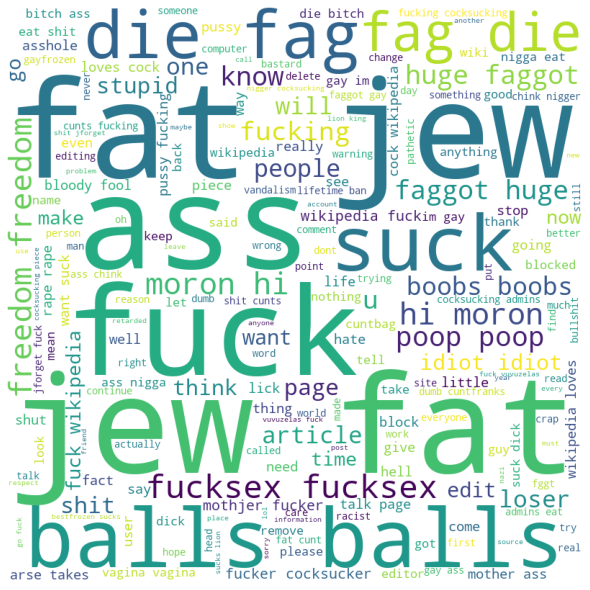

In [15]:
# build wordcloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# gather all comments that is classified as toxic
spotted_toxic_comments = []
index = 0
for i in range(len(predicted_result)):
  pred = list(predicted_result[i])
  indicator = pred.index(max(pred))
  if indicator != 6:
    spotted_toxic_comments.append(test_list[i][1])

# preprocess the sentences
input = ''
for val in spotted_toxic_comments:
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    input += " ".join(tokens)+" "

# build the wordcloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(input)
                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Model 2

LSTM

In [16]:
# import the packages
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import keras

In [17]:
# set up the embedding data file name
embedding_file=f'glove.6B.50d.txt'

In [18]:
# prepare the train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_sentences = train["comment_text"].fillna("unknown").values
test_sentences = test["comment_text"].fillna("unknown").values

classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[classes].values

In [19]:
# tokenize the train data
tokenizer = Tokenizer(num_words=22000)
tokenizer.fit_on_texts(list(train_sentences))

In [20]:
# put the texts into sequences
train_seq = tokenizer.texts_to_sequences(train_sentences)
test_seq = tokenizer.texts_to_sequences(test_sentences)

In [21]:
# pad the sequence to be prepared for embedding
train_padded_seq = pad_sequences(train_seq, maxlen=150)
test_padded_seq = pad_sequences(test_seq, maxlen=150)

In [22]:
# import the embedding file
def load_coeffients(word, *arr): 
  return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(load_coeffients(*i.strip().split()) for i in open(embedding_file))

In [23]:
# prepare the embeddings
all_embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = all_embeddings.mean(), all_embeddings.std()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [24]:
# build the embedding matrix
word_index = tokenizer.word_index
words_setup = min(22000, len(word_index))

embedding_matrix = np.random.normal(embedding_mean, embedding_std, (words_setup, 50))
for word, i in word_index.items():
    if i >= 22000: 
      continue
    curr = embeddings_index.get(word)
    if curr is not None: 
      embedding_matrix[i] = curr

In [25]:
# build the model
def build_model():

  # add inputs
  inp = Input(shape=(150,))

  # add embedding layer
  x = Embedding(22000, 50, weights=[embedding_matrix])(inp)

  # add LSTM later
  x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)

  # add global max pool layer
  x = GlobalMaxPool1D()(x)

  # add a 50 dense layer
  x = Dense(50, activation="relu")(x)

  # add a dropout layer
  x = Dropout(0.1)(x)

  # add the output layer
  x = Dense(6, activation="sigmoid")(x)

  # set up layer pipeline
  model = Model(inputs=inp, outputs=x)

  # compile the model with accuracy, precision, auc, recall
  model.compile(loss='binary_crossentropy', optimizer='adam', 
                metrics=['accuracy',
                        keras.metrics.Precision(),
                        keras.metrics.AUC(),
                        keras.metrics.Recall(),])
  return model

In [26]:
# train the model
model = build_model()
embedding_model = model.fit(train_padded_seq, y, batch_size=64, epochs=2, validation_split=0.1);

Epoch 1/2
2244/2244 [==============================] - 1095s 485ms/step - loss: 0.0631 - accuracy: 0.9048 - precision: 0.7672 - auc: 0.9685 - recall: 0.5761 - val_loss: 0.0492 - val_accuracy: 0.9940 - val_precision: 0.8318 - val_auc: 0.9807 - val_recall: 0.6457
Epoch 2/2
2244/2244 [==============================] - 1081s 482ms/step - loss: 0.0449 - accuracy: 0.9709 - precision: 0.8176 - auc: 0.9844 - recall: 0.6874 - val_loss: 0.0458 - val_accuracy: 0.9937 - val_precision: 0.8058 - val_auc: 0.9817 - val_recall: 0.7127


In [30]:
# save model to avoid repeated training
model.save("my_model")

In [ ]:
# load model
reconstructed_model = keras.models.load_model("my_model")

In [27]:
y_test = model.predict([test_padded_seq], batch_size=1024, verbose=1)

150/150 [==============================] - 106s 691ms/step


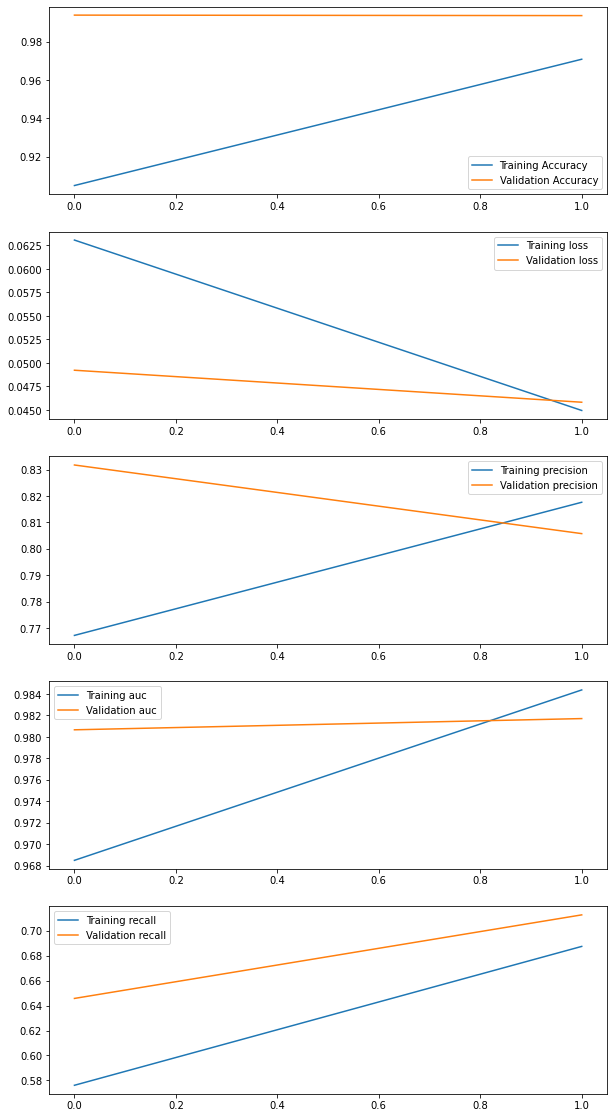

In [29]:
# plot the result

fig, axs = plt.subplots(5, figsize=(10,20))
axs[0].plot(embedding_model.history['accuracy'],label='Training Accuracy')
axs[0].plot(embedding_model.history['val_accuracy'],label='Validation Accuracy')

axs[0].legend()

axs[1].plot(embedding_model.history['loss'],label='Training loss')
axs[1].plot(embedding_model.history['val_loss'],label='Validation loss')

axs[1].legend()

axs[2].plot(embedding_model.history['precision'],label='Training precision')
axs[2].plot(embedding_model.history['val_precision'],label='Validation precision')

axs[2].legend()

axs[3].plot(embedding_model.history['auc'],label='Training auc')
axs[3].plot(embedding_model.history['val_auc'],label='Validation auc')

axs[3].legend()

axs[4].plot(embedding_model.history['recall'],label='Training recall')
axs[4].plot(embedding_model.history['val_recall'],label='Validation recall')

axs[4].legend()
plt.show()

# Visual


In [30]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 15.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7300e9c2efc928bbbbdabf9e5e6d5d0418a778a215f692883b1776b73d9f3d30
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=1bf8028d775946dd38e348304b0ef27be79f24236c63788847dab66908490dce
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [31]:
# import packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP

In [32]:
# load data
train = pd.read_csv('train.csv')
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
# do a tfidf on the data to vecterize them for later uses
tfidf = TfidfVectorizer() 
train = train.sample(10000)
docs = tfidf.fit_transform(train['comment_text'])
target = train['toxic']

In [34]:
# run umap
umap = UMAP(random_state=0)
g = umap.fit_transform(docs, target)

In [35]:
# set up color palette
palette = ["#0e08c4", "#03ad64"] # blue, green
color = [palette[0] if i==0 else palette[1] for i in target]

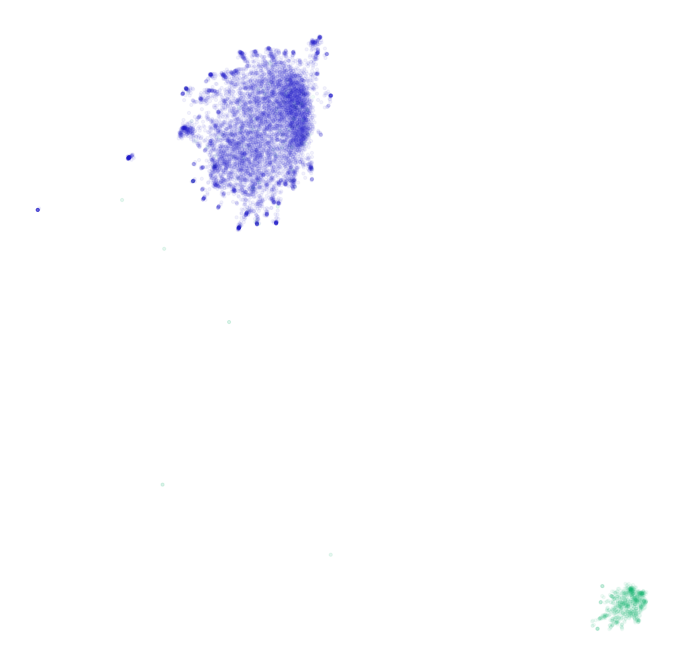

In [36]:
# plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.axis('off')

ax.scatter(x=g[:,0], y=g[:,1], s=10, alpha=0.05, c=color)

# fig.tight_layout()
plt.show()